**Question 1**

In [442]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import os
from pandas import Series, DataFrame

# def open_files():
#     directory = '/Users/piper/Piper Documents/R and Python/Project 2/DataRaw/Diabetes-Data/'
#     with open ('/Users/piper/Piper Documents/R and Python/Project 2/DataRaw/Diabetes-Data/all_data.txt', 'w') as output_file:
#         for data_file in os.listdir(directory):
#             if data_file != '.DS_Store':
#                 print('reading from ' + data_file)
#                 input_file_path = os.path.join(directory, data_file)            
#                 with open (input_file_path) as input_file:
#                     line = input_file.readline().strip()
#                     while line:
#                         output_line = line + '\t' + str(data_file) + '\n'
#                         output_file.write(output_line)
#                         line = input_file.readline().strip()
#                     input_file.close()
#         output_file.close()

# if __name__ == "__main__":
#     print('main')
#     open_files()
    

In [443]:
# read-in data
data = pd.read_csv('/Users/piper/Piper Documents/R and Python/Project 2/DataRaw/Diabetes-Data/all_data.txt', 
                   sep = '\t', header = None)
data_final = DataFrame(data)
data_final.columns = ['date', 'time', 'code', 'value', 'id']
data_final.shape

(29330, 5)

In [444]:
# exlude data anolamies in data-29 and data-27
data_final = data_final[(data_final[['date', 'time', 'code', 'value']] !='data-29' ).all(axis=1)]
data_final = data_final[(data_final[['date', 'time', 'code', 'value']] !='data-27' ).all(axis=1)]
data_final.shape

(29264, 5)

In [445]:
# exclude rows with non-numerical values, total rows excluded = 8
data_final = data_final[(data_final[['date', 'time', 'code', 'value']] !='0Hi' ).all(axis=1)]
data_final = data_final[(data_final[['date', 'time', 'code', 'value']] !='0Lo' ).all(axis=1)]
data_final = data_final[(data_final[['date', 'time', 'code', 'value']] !="0''" ).all(axis=1)]
data_final.shape

(29256, 5)

In [ ]:
# exclude wrongly-corrected dates
# talk to Katie about this issue

In [446]:
# prep data for future project questions
string = data_final['time'].str.split(':', n = 1, expand = True) 
data_final['hour'] = pd.to_numeric(string[0])
data_final['minutes'] = pd.to_numeric(string[1])
data_final['total_minutes'] = data_final['hour']*60 + data_final['minutes']
data_final.drop(['hour', 'minutes'], axis = 1, inplace = True)
data_final.head()

,date,time,code,value,id,total_minutes
0,05-20-1991,08:00,58,101,data-31,480
1,05-20-1991,08:00,33,005,data-31,480
2,05-20-1991,08:00,34,027,data-31,480
3,05-20-1991,12:00,60,089,data-31,720
4,05-20-1991,12:00,33,003,data-31,720


In [447]:
# create 'Part-of-Day' variable
bins = [0, ((11*60) + 59), ((16*60) + 59), ((24*60))]
labels = ['Morning', 'Afternoon', 'Evening']
data_final['part_of_day'] = pd.cut(data_final['total_minutes'], bins=bins, labels=labels, include_lowest=True)
data_final.head()

,date,time,code,value,id,total_minutes,part_of_day
0,05-20-1991,08:00,58,101,data-31,480,Morning
1,05-20-1991,08:00,33,005,data-31,480,Morning
2,05-20-1991,08:00,34,027,data-31,480,Morning
3,05-20-1991,12:00,60,089,data-31,720,Afternoon
4,05-20-1991,12:00,33,003,data-31,720,Afternoon


In [448]:
# convert 'value' column to numeric
data_final['value']=data_final.value.astype('float')
data_final.head()

,date,time,code,value,id,total_minutes,part_of_day
0,05-20-1991,08:00,58,101.0,data-31,480,Morning
1,05-20-1991,08:00,33,5.0,data-31,480,Morning
2,05-20-1991,08:00,34,27.0,data-31,480,Morning
3,05-20-1991,12:00,60,89.0,data-31,720,Afternoon
4,05-20-1991,12:00,33,3.0,data-31,720,Afternoon


**Question 2**

In [449]:
df_2 = data_final.loc[data_final['code'].isin(['58','59','60','61','62','63'])]
df_2 = df_2[['code', 'value']]
df_2.shape

(9749, 2)

In [450]:
group_2 = df_2.groupby(['code'])
median = group_2.quantile(0.5)
low_q = group_2.quantile(0.25)
high_q = group_2.quantile(0.75)

In [451]:
table_2 = pd.concat([median, low_q, high_q], axis=1)
table_2.columns = ['Median Glucose', '25th Percentile','75th Percentile']
table_2.rename(index = {'58':'Pre-Breakfast', '59':'Post-Breakfast', '60':'Pre-Lunch', 
                        '61':'Post-Lunch', '62':'Pre-Dinner', '63':'Post-Dinner'}, inplace = True)
del table_2.index.name
table_2

,Median Glucose,25th Percentile,75th Percentile
Pre-Breakfast,161.0,108.0,223.0
Post-Breakfast,190.5,87.0,230.0
Pre-Lunch,134.0,85.0,187.0
Post-Lunch,225.0,177.0,303.5
Pre-Dinner,147.0,99.0,201.0
Post-Dinner,183.0,104.0,257.0


**Question 3**

In [452]:
criteria = data_final.loc[data_final['code'].isin(['65','66','67','68','69','70','71','72'])].index
df_3 = data_final.loc[criteria, :]
group_3 = df_3.groupby(['id', 'code', 'part_of_day']).size().reset_index(name='freq')
group_3['indicator'] = 1
group_3.drop(['freq'], axis = 1, inplace = True)
group_3.head() #357 x 4, indicator means that patient had at least one recording of a specific code at that time

# not interested in how many recordings the patient had, just that they did had a recording

,id,code,part_of_day,indicator
0,data-01,65,Morning,1
1,data-01,65,Afternoon,1
2,data-01,65,Evening,1
3,data-03,65,Morning,1
4,data-03,65,Afternoon,1


In [453]:
table_3 = pd.crosstab(group_3['code'], group_3['part_of_day'])
table_3.rename(index = {'65':'Hypoglycemic Symptoms', '66':'Typical Meal Ingestion', 
                        '67':'More-than-Usual Meal Ingestion', 
                        '68':'Less-than-Usual Meal Ingestion', 
                        '69':'Typical Exercise Activity', '70':'More-than-Usual Exercise Activity',
                        '71':'Less-than-Usual Exercise Activity', '72':'Unspecified Special Event'}, inplace = True)
table_3 = table_3.rename_axis('').rename_axis('Patients with at Least 1 Recording', axis = 1)
table_3

Patients with at Least 1 Recording,Morning,Afternoon,Evening
,,,
Hypoglycemic Symptoms,31,20,22
Typical Meal Ingestion,11,9,8
More-than-Usual Meal Ingestion,30,15,32
Less-than-Usual Meal Ingestion,9,7,6
Typical Exercise Activity,10,6,14
More-than-Usual Exercise Activity,12,10,21
Less-than-Usual Exercise Activity,9,11,16
Unspecified Special Event,24,11,13


In [454]:
table_3b = round((table_3/70)*100, 2)
table_3b

Patients with at Least 1 Recording,Morning,Afternoon,Evening
,,,
Hypoglycemic Symptoms,44.29,28.57,31.43
Typical Meal Ingestion,15.71,12.86,11.43
More-than-Usual Meal Ingestion,42.86,21.43,45.71
Less-than-Usual Meal Ingestion,12.86,10.00,8.57
Typical Exercise Activity,14.29,8.57,20.00
More-than-Usual Exercise Activity,17.14,14.29,30.00
Less-than-Usual Exercise Activity,12.86,15.71,22.86
Unspecified Special Event,34.29,15.71,18.57


**Question 4**

In [455]:
criteria = data_final.loc[data_final['code'].isin(['33', '34', '35'])].index
df_4 = data_final.loc[criteria, :]
df_4.head()

,date,time,code,value,id,total_minutes,part_of_day
1,05-20-1991,08:00,33,5.0,data-31,480,Morning
2,05-20-1991,08:00,34,27.0,data-31,480,Morning
4,05-20-1991,12:00,33,3.0,data-31,720,Afternoon
6,05-20-1991,18:00,33,6.0,data-31,1080,Evening
9,05-21-1991,08:00,33,5.0,data-31,480,Morning


In [456]:
group_4 = df_4.groupby(['id', 'code', 'part_of_day'])[['value']].sum()
group_4 = group_4.dropna()
group_4 = group_4.reset_index()
group_4['type'] = group_4['code'].replace({'33': 'Regular', '34': 'NPH', '35': 'UltraLente'})
group_4.head()

,id,code,part_of_day,value,type
0,data-01,33,Morning,1245.0,Regular
1,data-01,33,Afternoon,471.0,Regular
2,data-01,33,Evening,816.0,Regular
3,data-01,34,Morning,2091.0,NPH
4,data-01,34,Evening,257.0,NPH


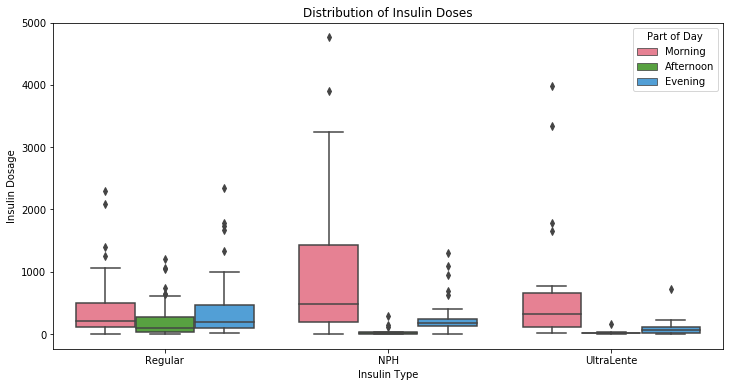

In [457]:
plt.figure(figsize=(12,6))
sns.boxplot(x='type', y='value', hue='part_of_day', data=group_4, palette='husl')
plt.title('Distribution of Insulin Doses')
plt.ylabel('Insulin Dosage')
plt.xlabel('Insulin Type')
plt.legend(title = 'Part of Day')
plt.show()

**Question 5**

In [463]:
criteria = data_final.loc[data_final['code'].isin(['48','57','58','59','60','61','62','63'])].index
df_5 = data_final.loc[criteria, :]
df_5['Date'] = pd.to_datetime(df_5['date'], errors = 'coerce')
df_5['time'] = [x + ':00' for x in df_5['time']]
df_5['Time'] = pd.to_timedelta(df_5['time'].astype(str))
df_5['datetime'] = pd.to_datetime(df_5['Date']+df_5['Time'])
df_5 = df_5.set_index('datetime')
df_5.head()

,date,time,code,value,id,total_minutes,part_of_day,Date,Time
datetime,,,,,,,,,
1991-05-20 08:00:00,05-20-1991,08:00:00,58,101.0,data-31,480,Morning,1991-05-20,08:00:00
1991-05-20 12:00:00,05-20-1991,12:00:00,60,89.0,data-31,720,Afternoon,1991-05-20,12:00:00
1991-05-20 18:00:00,05-20-1991,18:00:00,62,94.0,data-31,1080,Evening,1991-05-20,18:00:00
1991-05-20 22:00:00,05-20-1991,22:00:00,48,109.0,data-31,1320,Evening,1991-05-20,22:00:00
1991-05-21 08:00:00,05-21-1991,08:00:00,58,174.0,data-31,480,Morning,1991-05-21,08:00:00


In [464]:
df_5.shape

(12619, 9)

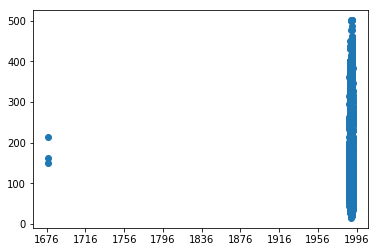

In [465]:
plt.scatter(df_5.index, df_5.loc[:,'value'])
plt.show() # found 3 outlier points, recorded in year 1675, need to fix, go fix in previous code as well

In [466]:
df_5 = df_5.loc['1950-01-01 00:00:00':'2010-01-01 00:00:00']
df_5.shape # deleted 3 outliers with incorrect times recorded

(12616, 9)

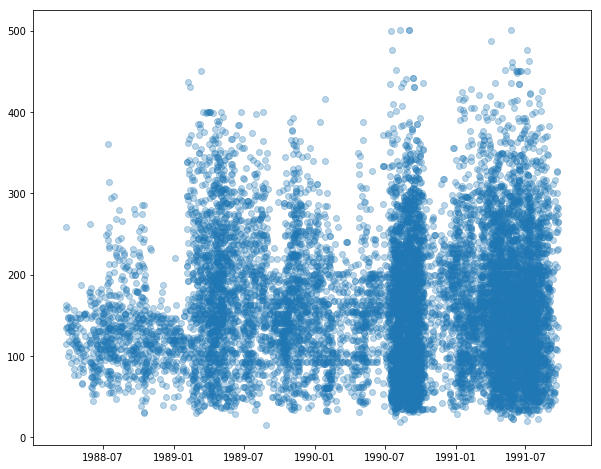

In [467]:
plt.figure(figsize=(10,8))
plt.scatter(df_5.index, df_5.loc[:,'value'], alpha = 0.3)
plt.show()